# Preprocesamiento y Filtrado de Bandas de Frecuencia

## Proyecto 1.b - Análisis de Grafos de Conectividad

**Objetivo**: Limpiar datos, filtrar en bandas de frecuencia, preparar para construcción de grafos

**Pipeline**:

1. Configuración e Instalación
2. Funciones de Carga de Datos (manejar diferentes frecuencias de muestreo)
3. Filtrado de Bandas de Frecuencia
4. Implementación de Ventana Deslizante
5. Procesamiento en Lotes
6. Validación de Datos

**Salida**: Datos preprocesados listos para correlación y construcción de grafos

- frecuencia de muestreo del EEG (~250 Hz) y la frecuencia de muestreo del audio (44,100 Hz)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy import signal
from pathlib import Path
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
%matplotlib inline

# Set random seed
np.random.seed(42)

print("✓ Libraries imported successfully!")

# Data paths
DATA_DIR = Path("data")
SLOW_DIR = DATA_DIR / "slow"
FAST_DIR = DATA_DIR / "fast"
OUTPUT_DIR = Path("preprocessed")
OUTPUT_DIR.mkdir(exist_ok=True)
(OUTPUT_DIR / "slow").mkdir(exist_ok=True)
(OUTPUT_DIR / "fast").mkdir(exist_ok=True)

# Good electrodes (Python indices)
GOOD_ELECTRODES_MATLAB = [
    2,
    3,
    4,
    6,
    7,
    9,
    11,
    12,
    13,
    14,
    15,
    16,
    18,
    19,
    20,
    21,
    22,
    24,
    25,
    26,
    27,
    28,
    30,
    31,
    33,
    34,
    36,
    38,
    40,
    41,
    42,
    44,
    45,
    46,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    56,
    57,
    58,
    59,
    60,
    65,
]
GOOD_ELECTRODES = [x - 1 for x in GOOD_ELECTRODES_MATLAB]
N_ELECTRODES = len(GOOD_ELECTRODES)

# Frequency bands (Hz)
FREQ_BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 50),
}

# Filter parameters
FILTER_ORDER = 4  # Butterworth filter order

# Sliding window parameters
WINDOW_SIZE_SEC = 1.0  # 1 second windows
OVERLAP_PERCENT = 0.75  # 75% overlap

# Sampling frequency (will be read from data)
FS = None

print("Configuration:")
print(f"  Data directory: {DATA_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Number of good electrodes: {N_ELECTRODES}")
print(f"  Frequency bands: {list(FREQ_BANDS.keys())}")
print(f"  Filter order: {FILTER_ORDER}")
print(f"  Window size: {WINDOW_SIZE_SEC} seconds")
print(f"  Window overlap: {OVERLAP_PERCENT * 100}%")

def load_eeg_file(filepath):
    """
    Load EEG data from .mat file and extract good electrodes.

    Parameters:
    -----------
    filepath : Path or str
        Path to .mat file

    Returns:
    --------
    eeg : ndarray, shape (n_good_electrodes, n_samples)
        EEG data from good electrodes only
    audio : ndarray, shape (n_samples,) or (n_samples, n_channels)
        Audio signal
    fs_eeg : int
        EEG sampling frequency (calculated)
    fs_audio : int
        Audio sampling frequency
    """
    data = loadmat(filepath)

    # Extract components
    eeg_all = data["subeeg"]
    audio = data["y"]
    fs_audio = int(data["Fs"][0, 0])

    # Check if EEG data needs transposing
    # EEG should be (n_samples, n_electrodes), we want (n_electrodes, n_samples)
    if eeg_all.shape[0] > eeg_all.shape[1]:
        eeg_all = eeg_all.T

    # Extract only good electrodes
    eeg = eeg_all[GOOD_ELECTRODES, :]

    # Calculate EEG sampling rate from audio duration
    audio_duration = audio.shape[0] / fs_audio
    fs_eeg = int(round(eeg.shape[1] / audio_duration))

    # Flatten audio if stereo
    if audio.ndim > 1:
        audio = audio.mean(axis=1)

    return eeg, audio, fs_eeg, fs_audio


# Test the function
test_file = list(SLOW_DIR.glob("*.mat"))[0]
eeg_test, audio_test, fs_eeg_test, fs_audio_test = load_eeg_file(test_file)
print(f"✓ Test file loaded: {test_file.name}")
print(f"  EEG shape: {eeg_test.shape} (electrodes × samples)")
print(f"  Audio shape: {audio_test.shape}")
print(f"  EEG sampling frequency: {fs_eeg_test} Hz")
print(f"  Audio sampling frequency: {fs_audio_test} Hz")
print(f"  EEG duration: {eeg_test.shape[1] / fs_eeg_test:.2f} seconds")
print(f"  Audio duration: {audio_test.shape[0] / fs_audio_test:.2f} seconds")

# Store sampling frequencies globally
FS_EEG = fs_eeg_test
FS_AUDIO = fs_audio_test
print(f"\n✓ Using EEG sampling frequency: {FS_EEG} Hz for all processing")


def design_bandpass_filter(lowcut, highcut, fs, order=4):
    """
    Design a Butterworth bandpass filter.

    Parameters:
    -----------
    lowcut : float
        Lower frequency bound (Hz)
    highcut : float
        Upper frequency bound (Hz)
    fs : int
        Sampling frequency (Hz)
    order : int
        Filter order

    Returns:
    --------
    sos : ndarray
        Second-order sections representation of the filter
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(order, [low, high], btype="band", output="sos")
    return sos


def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply bandpass filter to data.

    Parameters:
    -----------
    data : ndarray, shape (n_channels, n_samples)
        Input data
    lowcut : float
        Lower frequency bound (Hz)
    highcut : float
        Upper frequency bound (Hz)
    fs : int
        Sampling frequency (Hz)
    order : int
        Filter order

    Returns:
    --------
    filtered_data : ndarray, shape (n_channels, n_samples)
        Filtered data
    """
    sos = design_bandpass_filter(lowcut, highcut, fs, order)

    # Apply filter to each channel using zero-phase filtering
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        filtered_data[i, :] = signal.sosfiltfilt(sos, data[i, :])

    return filtered_data


# Test filtering on one band
print("Testing bandpass filter...")
lowcut, highcut = FREQ_BANDS["alpha"]
eeg_filtered = apply_bandpass_filter(eeg_test, lowcut, highcut, FS_EEG, FILTER_ORDER)
print(f"✓ Alpha band filter applied: {lowcut}-{highcut} Hz")
print(f"  EEG sampling rate used: {FS_EEG} Hz")
print(f"  Input shape: {eeg_test.shape}")
print(f"  Output shape: {eeg_filtered.shape}")

✓ Libraries imported successfully!


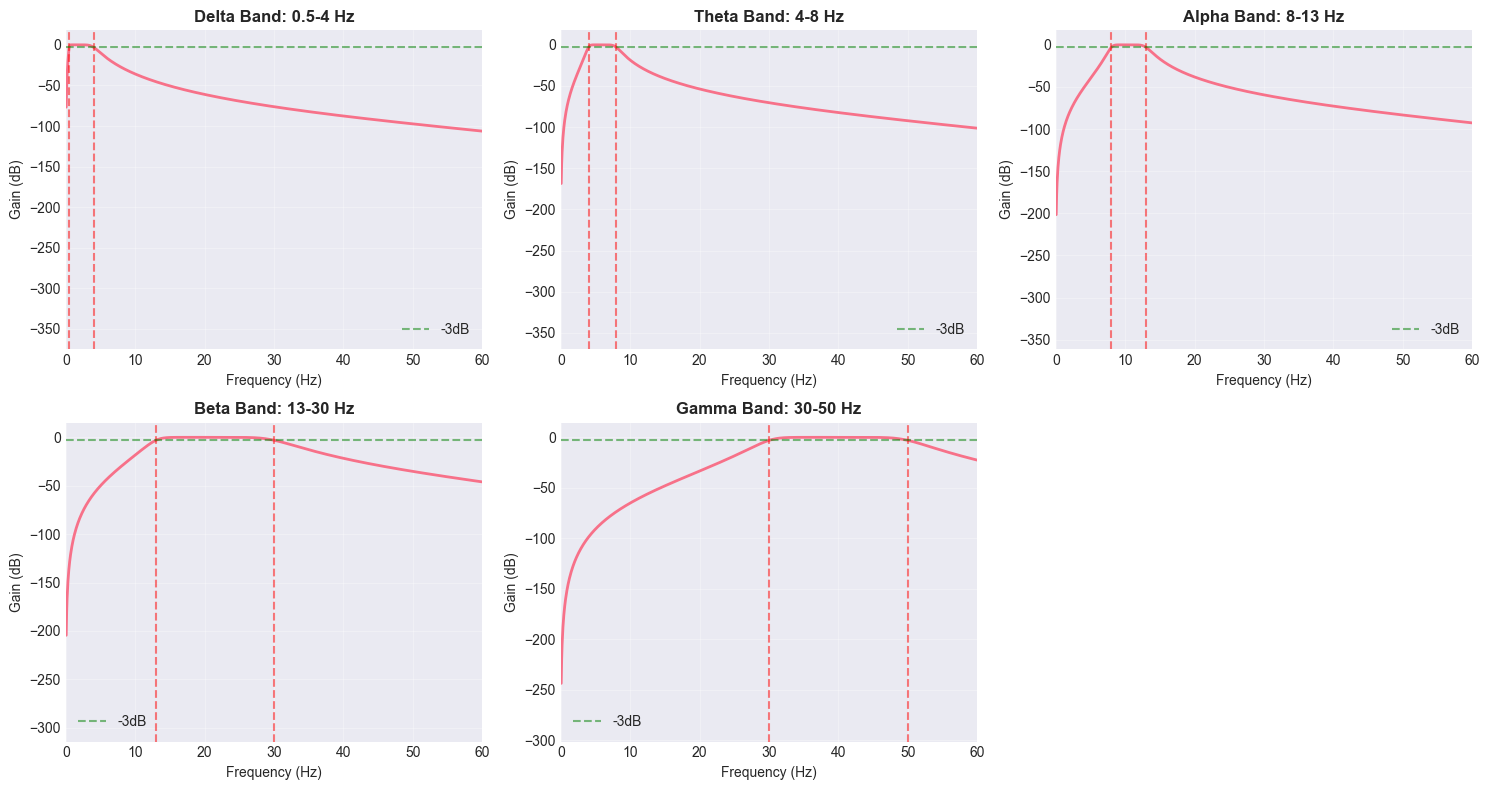

✓ Filter frequency responses validated (EEG Fs = 250 Hz)


In [ ]:
# Plot frequency response of all filters
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (band_name, (lowcut, highcut)) in enumerate(FREQ_BANDS.items()):
    sos = design_bandpass_filter(lowcut, highcut, FS_EEG, FILTER_ORDER)
    w, h = signal.sosfreqz(sos, worN=2000, fs=FS_EEG)

    axes[idx].plot(w, 20 * np.log10(abs(h)), linewidth=2)
    axes[idx].set_title(
        f"{band_name.capitalize()} Band: {lowcut}-{highcut} Hz", fontweight="bold"
    )
    axes[idx].set_xlabel("Frequency (Hz)")
    axes[idx].set_ylabel("Gain (dB)")
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 60])
    axes[idx].axvline(lowcut, color="r", linestyle="--", alpha=0.5)
    axes[idx].axvline(highcut, color="r", linestyle="--", alpha=0.5)
    axes[idx].axhline(-3, color="g", linestyle="--", alpha=0.5, label="-3dB")
    axes[idx].legend()

# Remove extra subplot
axes[-1].remove()

plt.tight_layout()
plt.show()
print(f"✓ Filter frequency responses validated (EEG Fs = {FS_EEG} Hz)")


def create_sliding_windows(data, window_size, overlap, fs):
    """
    Create sliding windows from continuous data.

    Parameters:
    -----------
    data : ndarray, shape (n_channels, n_samples)
        Input data
    window_size : float
        Window size in seconds
    overlap : float
        Overlap fraction (0-1)
    fs : int
        Sampling frequency

    Returns:
    --------
    windows : ndarray, shape (n_windows, n_channels, window_samples)
        Windowed data
    window_times : ndarray, shape (n_windows,)
        Center time of each window in seconds
    """
    n_channels, n_samples = data.shape
    window_samples = int(window_size * fs)
    step_samples = int(window_samples * (1 - overlap))

    # Calculate number of windows
    n_windows = (n_samples - window_samples) // step_samples + 1

    # Handle edge case where recording is too short
    if n_windows < 1:
        print(
            f"Warning: Recording too short for {window_size}s windows (only {n_samples / fs:.2f}s)"
        )
        return np.array([]), np.array([])

    # Preallocate array
    windows = np.zeros((n_windows, n_channels, window_samples))
    window_times = np.zeros(n_windows)

    # Extract windows
    for i in range(n_windows):
        start_idx = i * step_samples
        end_idx = start_idx + window_samples

        if end_idx <= n_samples:
            windows[i, :, :] = data[:, start_idx:end_idx]
            window_times[i] = (start_idx + window_samples // 2) / fs

    return windows, window_times


# Test sliding window function
windows_test, times_test = create_sliding_windows(
    eeg_filtered, WINDOW_SIZE_SEC, OVERLAP_PERCENT, FS_EEG
)

print(f"✓ Sliding windows created")
print(f"  Input shape: {eeg_filtered.shape}")
print(f"  Window shape: {windows_test.shape}")
print(f"  Number of windows: {windows_test.shape[0]}")
print(f"  Window size: {WINDOW_SIZE_SEC}s = {int(WINDOW_SIZE_SEC * FS_EEG)} samples")
print(f"  Step size: {int(WINDOW_SIZE_SEC * FS_EEG * (1 - OVERLAP_PERCENT))} samples")
if len(times_test) > 0:
    print(f"  Time range: {times_test[0]:.2f}s to {times_test[-1]:.2f}s")

In [ ]:
def preprocess_file(
    filepath, output_dir, freq_bands, window_size, overlap, fs_eeg, filter_order=4
):
    """
    Complete preprocessing pipeline for a single file.

    Steps:
    1. Load EEG data (good electrodes only)
    2. Filter into frequency bands
    3. Create sliding windows for each band
    4. Save preprocessed data

    Parameters:
    -----------
    filepath : Path
        Path to input .mat file
    output_dir : Path
        Directory to save preprocessed data
    freq_bands : dict
        Dictionary of frequency bands {name: (low, high)}
    window_size : float
        Window size in seconds
    overlap : float
        Overlap fraction (0-1)
    fs_eeg : int
        EEG sampling frequency
    filter_order : int
        Butterworth filter order

    Returns:
    --------
    metadata : dict
        Metadata about the processed file
    """
    # Load data
    eeg, audio, fs_eeg_file, fs_audio = load_eeg_file(filepath)

    # Verify sampling frequency matches expected
    if abs(fs_eeg_file - fs_eeg) > 1:  # Allow 1 Hz tolerance
        print(
            f"Warning: EEG sampling frequency mismatch in {filepath.name}: {fs_eeg_file} Hz vs expected {fs_eeg} Hz"
        )
        # Use the file's actual sampling rate
        fs_eeg = fs_eeg_file

    # Create output directory for this file
    file_output_dir = output_dir / filepath.stem
    file_output_dir.mkdir(exist_ok=True)

    # Process each frequency band
    band_metadata = {}
    windows_shape = None
    window_times = None

    for band_name, (lowcut, highcut) in freq_bands.items():
        # Filter
        eeg_filtered = apply_bandpass_filter(eeg, lowcut, highcut, fs_eeg, filter_order)

        # Create windows
        windows, window_times = create_sliding_windows(
            eeg_filtered, window_size, overlap, fs_eeg
        )

        # Skip if no windows could be created
        if windows.shape[0] == 0:
            continue

        # Save windowed data
        output_file = file_output_dir / f"{band_name}.npy"
        np.save(output_file, windows)

        band_metadata[band_name] = {
            "n_windows": windows.shape[0],
            "window_shape": windows.shape,
            "freq_range": (lowcut, highcut),
        }

        windows_shape = windows.shape

    # If no windows were created, return None
    if windows_shape is None or windows_shape[0] == 0:
        return None

    # Save window times (same for all bands)
    np.save(file_output_dir / "window_times.npy", window_times)

    # Save audio (for future use)
    np.save(file_output_dir / "audio.npy", audio)

    # Metadata
    metadata = {
        "filename": filepath.name,
        "n_electrodes": eeg.shape[0],
        "n_samples": eeg.shape[1],
        "duration_sec": eeg.shape[1] / fs_eeg,
        "fs_eeg": fs_eeg,
        "bands": band_metadata,
        "n_windows": windows_shape[0],
    }

    return metadata


# Test on one file
print("Testing preprocessing pipeline on one file...")
test_output = OUTPUT_DIR / "slow"
metadata_test = preprocess_file(
    test_file,
    test_output,
    FREQ_BANDS,
    WINDOW_SIZE_SEC,
    OVERLAP_PERCENT,
    FS_EEG,
    FILTER_ORDER,
)

if metadata_test is not None:
    print("\n✓ Preprocessing test successful!")
    print(f"  File: {metadata_test['filename']}")
    print(f"  Duration: {metadata_test['duration_sec']:.2f}s")
    print(f"  EEG sampling rate: {metadata_test['fs_eeg']} Hz")
    print(f"  Number of windows: {metadata_test['n_windows']}")
    print(f"  Bands processed: {list(metadata_test['bands'].keys())}")
else:
    print("\n✗ Preprocessing test failed - file too short")


def batch_preprocess(
    input_dir, output_dir, freq_bands, window_size, overlap, fs_eeg, filter_order=4
):
    """
    Preprocess all files in a directory.

    Parameters:
    -----------
    input_dir : Path
        Directory containing .mat files
    output_dir : Path
        Directory to save preprocessed data
    freq_bands : dict
        Dictionary of frequency bands
    window_size : float
        Window size in seconds
    overlap : float
        Overlap fraction
    fs_eeg : int
        EEG sampling frequency
    filter_order : int
        Filter order

    Returns:
    --------
    all_metadata : list
        List of metadata dictionaries for all processed files
    """
    files = sorted(list(input_dir.glob("*.mat")))
    all_metadata = []
    failed_files = []

    print(f"Processing {len(files)} files from {input_dir.name}...")

    for filepath in tqdm(files, desc="Preprocessing"):
        try:
            metadata = preprocess_file(
                filepath,
                output_dir,
                freq_bands,
                window_size,
                overlap,
                fs_eeg,
                filter_order,
            )
            if metadata is not None:
                all_metadata.append(metadata)
            else:
                failed_files.append(filepath.name)
        except Exception as e:
            print(f"\nError processing {filepath.name}: {str(e)}")
            failed_files.append(filepath.name)

    print(f"\n✓ Preprocessing complete!")
    print(f"  Successfully processed: {len(all_metadata)} files")
    print(f"  Failed: {len(failed_files)} files")

    if failed_files:
        print(f"  Failed files: {failed_files[:5]}...")

    return all_metadata, failed_files


# Process slow files
print("=" * 60)
print("PROCESSING SLOW AUDIO FILES")
print("=" * 60)
metadata_slow, failed_slow = batch_preprocess(
    SLOW_DIR,
    OUTPUT_DIR / "slow",
    FREQ_BANDS,
    WINDOW_SIZE_SEC,
    OVERLAP_PERCENT,
    FS_EEG,
    FILTER_ORDER,
)

# Process fast files
print("\n" + "=" * 60)
print("PROCESSING FAST AUDIO FILES")
print("=" * 60)
metadata_fast, failed_fast = batch_preprocess(
    FAST_DIR,
    OUTPUT_DIR / "fast",
    FREQ_BANDS,
    WINDOW_SIZE_SEC,
    OVERLAP_PERCENT,
    FS_EEG,
    FILTER_ORDER,
)

Testing preprocessing pipeline on one file...

✓ Preprocessing test successful!
  File: bb19_ut04.mat
  Duration: 22.06s
  EEG sampling rate: 250 Hz
  Number of windows: 85
  Bands processed: ['delta', 'theta', 'alpha', 'beta', 'gamma']


In [9]:
# Create summary DataFrames
df_slow = pd.DataFrame(metadata_slow)
df_fast = pd.DataFrame(metadata_fast)

# Add condition labels
df_slow["condition"] = "slow"
df_fast["condition"] = "fast"

# Combine
df_all = pd.concat([df_slow, df_fast], ignore_index=True)

# Save metadata
df_all.to_csv(OUTPUT_DIR / "preprocessing_metadata.csv", index=False)
print(f"✓ Metadata saved to {OUTPUT_DIR / 'preprocessing_metadata.csv'}")

# Display summary statistics
print("\n" + "=" * 60)
print("PREPROCESSING SUMMARY")
print("=" * 60)
print(f"\nTotal files processed: {len(df_all)}")
print(f"  Slow: {len(df_slow)}")
print(f"  Fast: {len(df_fast)}")

print(f"\nDuration statistics:")
print(f"  Mean: {df_all['duration_sec'].mean():.2f}s")
print(f"  Std: {df_all['duration_sec'].std():.2f}s")
print(f"  Min: {df_all['duration_sec'].min():.2f}s")
print(f"  Max: {df_all['duration_sec'].max():.2f}s")

print(f"\nWindows per file:")
print(f"  Mean: {df_all['n_windows'].mean():.1f}")
print(f"  Std: {df_all['n_windows'].std():.1f}")
print(f"  Min: {df_all['n_windows'].min()}")
print(f"  Max: {df_all['n_windows'].max()}")

print(f"\nTotal windows across all files:")
print(f"  Slow: {df_slow['n_windows'].sum()}")
print(f"  Fast: {df_fast['n_windows'].sum()}")
print(f"  Total: {df_all['n_windows'].sum()}")

✓ Metadata saved to preprocessed/preprocessing_metadata.csv

PREPROCESSING SUMMARY

Total files processed: 1416
  Slow: 710
  Fast: 706

Duration statistics:
  Mean: 16.97s
  Std: 4.15s
  Min: 10.65s
  Max: 22.96s

Windows per file:
  Mean: 64.9
  Std: 16.8
  Min: 39
  Max: 89

Total windows across all files:
  Slow: 57288
  Fast: 34559
  Total: 91847


## validar Preprocessed Data


Loading preprocessed data from: bb19_ut04
  delta: (85, 47, 250)
  theta: (85, 47, 250)
  alpha: (85, 47, 250)
  beta: (85, 47, 250)
  gamma: (85, 47, 250)


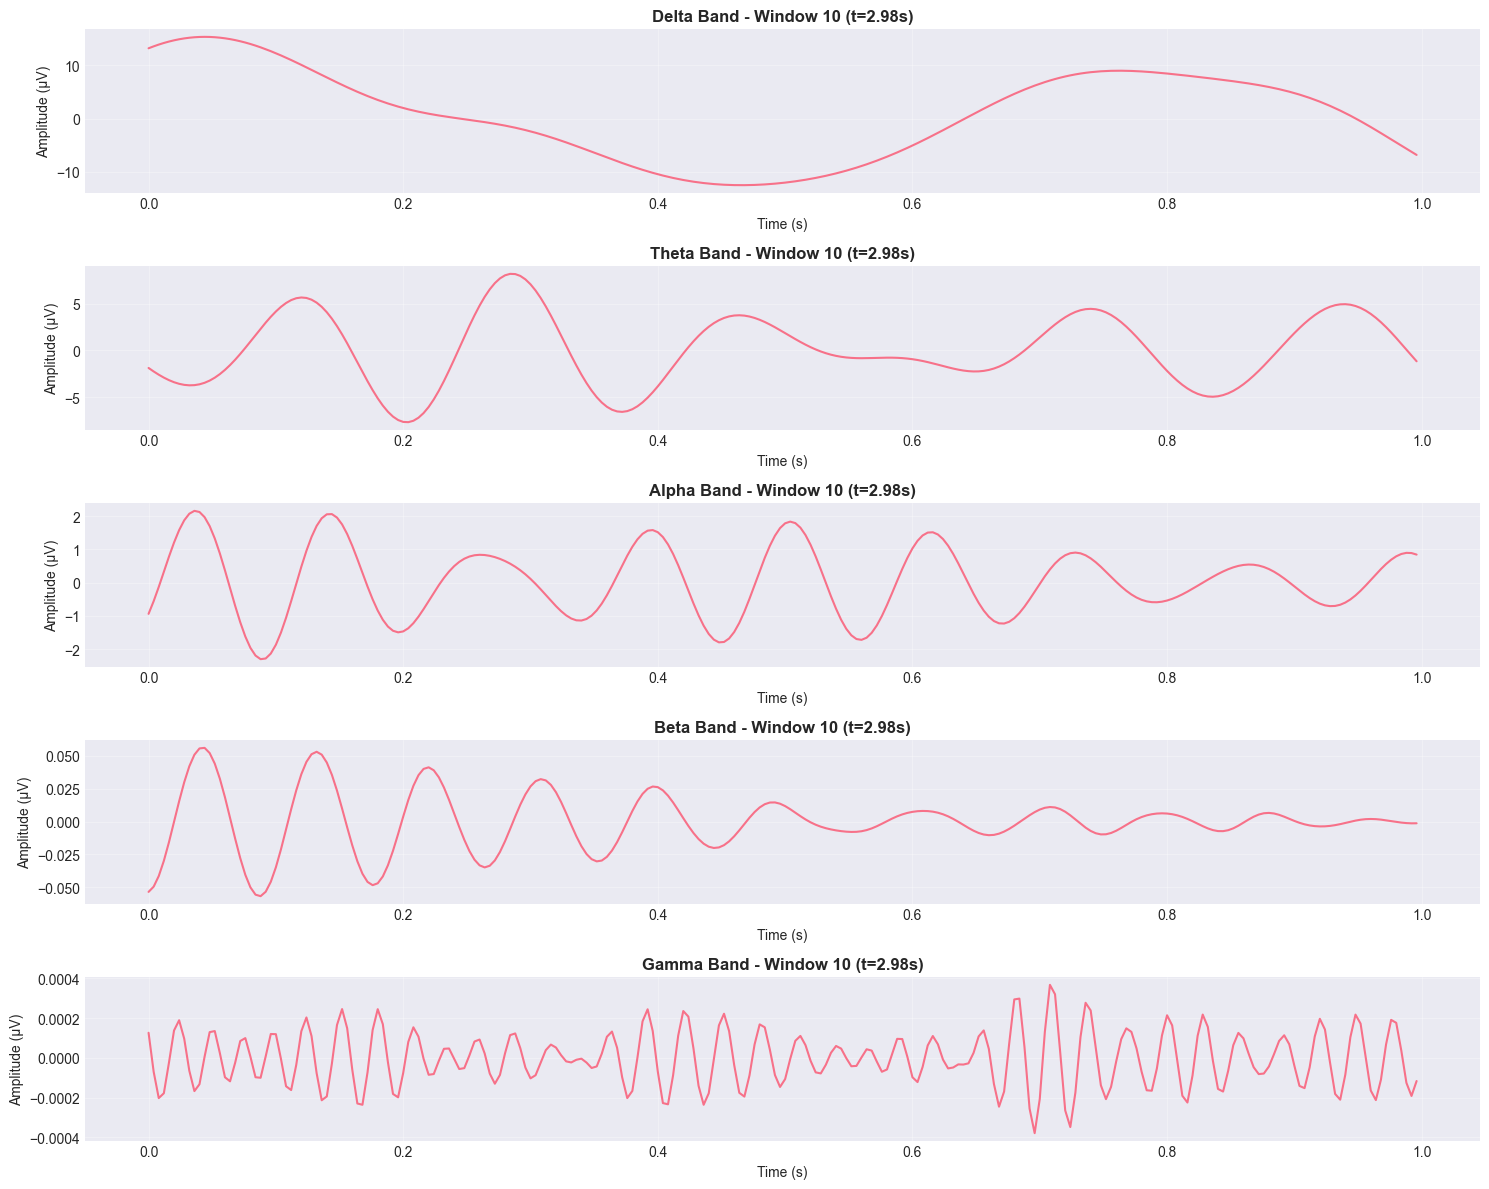


✓ Preprocessed data validated successfully!
  EEG sampling rate used: 250 Hz


In [10]:
# Load a preprocessed file to validate
sample_preprocessed_dir = OUTPUT_DIR / "slow" / test_file.stem

print(f"Loading preprocessed data from: {sample_preprocessed_dir.name}")

# Load all bands
bands_data = {}
for band_name in FREQ_BANDS.keys():
    band_file = sample_preprocessed_dir / f"{band_name}.npy"
    if band_file.exists():
        bands_data[band_name] = np.load(band_file)
        print(f"  {band_name}: {bands_data[band_name].shape}")

window_times = np.load(sample_preprocessed_dir / "window_times.npy")

# Plot one window from each band
fig, axes = plt.subplots(5, 1, figsize=(15, 12))

window_idx = 10  # Plot 10th window
electrode_idx = 0  # First electrode

for idx, (band_name, data) in enumerate(bands_data.items()):
    time_axis = np.arange(data.shape[2]) / FS_EEG
    axes[idx].plot(time_axis, data[window_idx, electrode_idx, :], linewidth=1.5)
    axes[idx].set_title(
        f"{band_name.capitalize()} Band - Window {window_idx} (t={window_times[window_idx]:.2f}s)",
        fontweight="bold",
    )
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Amplitude (μV)")
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Preprocessed data validated successfully!")
print(f"  EEG sampling rate used: {FS_EEG} Hz")

### resumen

1. Loaded all EEG files (slow and fast conditions)
2. Correctly identified EEG sampling rate (~250 Hz) vs audio sampling rate (44,100 Hz)
3. Transposed EEG data to correct orientation (electrodes × samples)
4. Extracted only good electrodes (47 channels)
5. Applied Butterworth bandpass filters for 5 frequency bands:
   - Delta (0.5-4 Hz)
   - Theta (4-8 Hz)
   - Alpha (8-13 Hz)
   - Beta (13-30 Hz)
   - Gamma (30-50 Hz)
6. Created sliding windows (1s, 75% overlap) using correct EEG sampling rate
7. Saved preprocessed data in organized structure

---

- EEG sampling frequency: ~250 Hz
- Audio sampling frequency: 44,100 Hz
- Window size: 1 second = ~250 samples
- Window overlap: 75% = step size of ~62-63 samples
- Filter order: 4 (Butterworth)

**Output Structure:**

```
preprocessed/
├── slow/
│   ├── bb01_ut01/
│   │   ├── delta.npy (n_windows, 47, 250)
│   │   ├── theta.npy
│   │   ├── alpha.npy
│   │   ├── beta.npy
│   │   ├── gamma.npy
│   │   ├── window_times.npy
│   │   └── audio.npy
│   └── ...
├── fast/
│   └── ...
└── preprocessing_metadata.csv
```

**Next Steps:**

- Compute correlations between electrodes for each window
- Build weighted connectivity graphs
- Create time series of graphs for TDA analysis
